In [43]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from collections import Counter
from torch.utils.data import DataLoader, WeightedRandomSampler, TensorDataset
from sklearn.utils.class_weight import compute_class_weight
import torch.optim as optim
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
base_dir = "SKAB"

In [91]:
# Load data from directories into a dataframe that contains the raw data and a label for anomaly/no anomaly
def load_data(base_dir):
    data = []
    labels = []
    for folder in ["anomaly-free", "other", "valve1", "valve2"]:
        folder_path = os.path.join(base_dir, folder)
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            # Load the CSV file and parse the 'datetime' column
            df = pd.read_csv(file_path, sep=";", parse_dates=["datetime"])
            
            # Assign labels based on the folder and check if 'anomaly' column exists
            if folder == "anomaly-free":
                # If the folder is 'anomaly-free', assign a 0 label (no anomaly) for all rows
                data.append(df)
                labels.extend([0] * len(df))
            else:
                data.append(df)  # Add to data list for other folders as well
                
                # For other folders, check for the 'anomaly' column
                if "anomaly" in df.columns:
                    labels.extend(df["anomaly"].tolist())  # Use 'anomaly' column for labeling
                else:
                    print("Anomaly column not in data:", file_path)
    
    # Concatenate the data from all files
    df_combined = pd.concat(data, ignore_index=True)
    
    # Sort the concatenated dataframe by 'datetime' to maintain the temporal order
    df_combined = df_combined.sort_values(by="datetime")
    
    return df_combined, labels

In [93]:
# Load and preprocess data
all_data_df, data_labels = load_data(base_dir)

In [94]:
print(len(all_data_df), len(data_labels))

46860 46860


In [95]:
# Understand class imbalance
label_counts = Counter(data_labels)

# Display the counts for each class
for label, count in label_counts.items():
    print(f"Class {int(label)}: {count} samples")

Class 0: 33619 samples
Class 1: 13241 samples


In [96]:
# Create sequences/chunks of data that will be fed to the GRU model. The target will be the label at the next time step.
def create_sequences(data, labels, sequence_length):    
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(labels[i + sequence_length])
    return np.array(X), np.array(y)

In [130]:
def preprocess_data(df, labels, sequence_length=8):
    # Exclude columns that could cause data leakage (e.g., "anomaly" or "changepoint")
    columns_to_exclude = ["anomaly", "changepoint"]
    for col in columns_to_exclude:
        if col in df.columns:
            df = df.drop(columns=[col])
    
    # Only want to use the MinMaxScaler on numerical data, not the datetime
    numeric_data = df.select_dtypes(include=["float64", "int64"])
    
    # Scale the numerical data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(numeric_data)
    
    # Create sequences and shuffle with labels
    X, y = create_sequences(scaled_data, labels, sequence_length)
    X, y = shuffle(X, y, random_state=42)

    # Split with stratification
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=42
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
    )
    return X_train, X_val, X_test, y_train, y_val, y_test

In [131]:
SEQ_LENGTH = 16
X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data(all_data_df, data_labels, SEQ_LENGTH)

print(X_train.shape)
# Outputs for inspection
print("Train set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))

(32790, 16, 8)
Train set size: 32790
Validation set size: 7027
Test set size: 7027


In [64]:
# Define the GRU model
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.2, bidirectional=True):
        super(GRUModel, self).__init__()
        self.model_type = "GRU"
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        
        # GRU layer with bidirectional option
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,  # Dropout only applied if num_layers > 1
            bidirectional=bidirectional
        )
        
        # Batch normalization for the GRU output
        self.batch_norm = nn.BatchNorm1d(hidden_size * 2 if bidirectional else hidden_size)
        
        # Fully connected layer mapping GRU output to target output size
        self.fc = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, output_size)
        
        # Dropout for regularization before fully connected layer
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Determine batch size dynamically
        batch_size = x.size(0)
        
        # Initialize hidden state
        h0 = torch.zeros(
            self.num_layers * (2 if self.bidirectional else 1),  # Double layers for bidirectional
            batch_size,
            self.hidden_size
        ).to(x.device)  # Ensure the hidden state is on the same device as input

        # GRU forward pass
        out, _ = self.gru(x, h0)
        
        # Apply batch normalization to the last time step output
        out_last = out[:, -1, :]  # Get the output of the last time step
        out_last = self.batch_norm(out_last)
    
        # Apply dropout and fully connected layer
        out_last = self.dropout(out_last)
        out = self.fc(out_last)
        
        return out

In [132]:
def create_dataloaders(X_train, X_val, X_test, y_train, y_val, y_test, batch_size=32):
    # Convert the data and labels into PyTorch tensors
    train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
    val_data = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
    test_data = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))
    
    # Compute class weights for CrossEntropyLoss
    class_weights = compute_class_weight(
        class_weight='balanced', 
        classes=np.array([0, 1]), 
        y=y_train
    )
    class_weights = torch.tensor(class_weights, dtype=torch.float32)
    
    # Create the WeightedRandomSampler for the training data
    # The sampler will use the weights calculated from the class distribution
    class_sample_count = [len(torch.nonzero(torch.tensor(y_train) == i)) for i in [0, 1]]
    weights = [class_weights[int(label)] for label in y_train]
    sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

    # Create DataLoader for training, validation, and test sets
    train_loader = DataLoader(train_data, batch_size=batch_size, sampler=sampler)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader, class_weights

In [133]:
# Define hyperparameters
input_size = 8  # Number of features
hidden_size = 64  # Hidden state dimension
output_size = 2  # Number of classes (normal, anomaly)
num_layers = 2
num_epochs = 50
batch_size = 64
learning_rate = 0.0005
weight_decay = 0.001
dropout = 0.3

model = GRUModel(input_size, hidden_size, output_size, num_layers, dropout=dropout).to(device)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',       # Reduce the LR when the validation loss stops improving
    factor=0.5,       # Reduce the LR by half
    patience=4,       # Wait for 5 epochs before reducing LR
    min_lr=1e-6       # Minimum learning rate
)
criterion = nn.CrossEntropyLoss(weight=class_weights.clone().detach().to(device))

# Create the dataloaders and get class weights for loss function
train_loader, val_loader, test_loader, class_weights = create_dataloaders(X_train, X_val, X_test, 
                                                                          y_train, y_val, y_test, batch_size=batch_size)

In [134]:
# Training loop
best_val_F1 = -1.0
best_model_path = "best_model.pth"
all_training_f1 = []
all_validation_f1 = []

# Add tracking for F1 score
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct, total = 0, 0
    all_preds, all_targets = [], []

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track metrics
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == targets).sum().item()
        total += targets.size(0)
        
        # Collect predictions and targets for F1 score
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

    train_acc = correct / total
    train_f1 = f1_score(all_targets, all_preds, average='macro')
    all_training_f1.append(train_f1)
    print(f"\nEpoch {epoch+1}/{num_epochs}, Train F1 Score: {train_f1:.4f}")

    # Validation loop
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    val_preds, val_targets = [], []
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == targets).sum().item()
            val_total += targets.size(0)

            # Collect predictions and targets for F1 score
            val_preds.extend(predicted.cpu().numpy())
            val_targets.extend(targets.cpu().numpy())

    val_accuracy = 100 * val_correct / val_total
    avg_val_loss = val_loss / len(val_loader)
    val_f1 = f1_score(val_targets, val_preds, average='macro')
    all_validation_f1.append(val_f1)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation F1 Score: {val_f1:.4f}")

    # Save the model if validation loss has improved
    if val_f1 > best_val_F1:
        best_val_F1 = val_f1
        torch.save(model.state_dict(), best_model_path)
        print(f"Model saved with validation F1 score: {val_f1:.4f}")

    # Step the scheduler after validation based on validation F1
    scheduler.step(val_f1)


Epoch 1/50, Train F1 Score: 0.4867
Validation Loss: 0.7190, Validation F1 Score: 0.2636
Model saved with validation F1 score: 0.2636

Epoch 2/50, Train F1 Score: 0.5447
Validation Loss: 0.6564, Validation F1 Score: 0.4292
Model saved with validation F1 score: 0.4292

Epoch 3/50, Train F1 Score: 0.5588
Validation Loss: 0.6330, Validation F1 Score: 0.4927
Model saved with validation F1 score: 0.4927

Epoch 4/50, Train F1 Score: 0.5606
Validation Loss: 0.6469, Validation F1 Score: 0.4450

Epoch 5/50, Train F1 Score: 0.5658
Validation Loss: 0.5935, Validation F1 Score: 0.5631
Model saved with validation F1 score: 0.5631

Epoch 6/50, Train F1 Score: 0.5969
Validation Loss: 0.5710, Validation F1 Score: 0.6375
Model saved with validation F1 score: 0.6375

Epoch 7/50, Train F1 Score: 0.6451
Validation Loss: 0.5701, Validation F1 Score: 0.4875

Epoch 8/50, Train F1 Score: 0.6527
Validation Loss: 0.5206, Validation F1 Score: 0.5752

Epoch 9/50, Train F1 Score: 0.6693
Validation Loss: 0.8693, Va

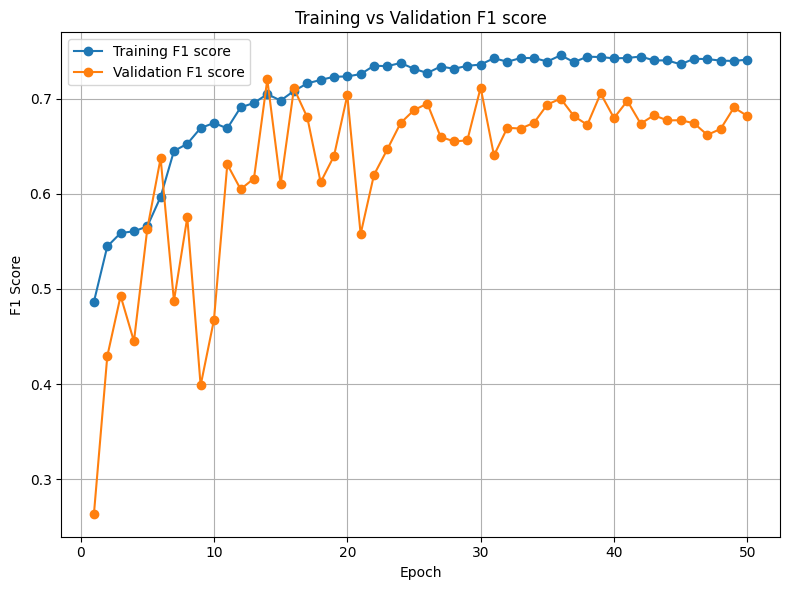

In [136]:
# Plot the loss and F1 score vs training epoch
epochs = range(1, len(all_training_f1) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, all_training_f1, label='Training F1 score', marker='o')
plt.plot(epochs, all_validation_f1, label='Validation F1 score', marker='o')
plt.title('Training vs Validation F1 score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [137]:
# Load the best model weights before validation
model.load_state_dict(torch.load(best_model_path, weights_only=True))
print("Loaded best model weights from validation.")

test_loss = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)
        test_loss += loss.item()

        # Predictions and labels
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average="macro")

print(f"Test Loss: {test_loss / len(test_loader):.4f}")
print(f"Test Accuracy: {accuracy:.2%}")
print(f"Test Precision: {precision:.2}")
print(f"Test Recall: {recall:.2}")
print(f"Test F1 Score: {f1:.4f}")

Loaded best model weights from validation.
Test Loss: 0.5637
Test Accuracy: 73.64%
Test Precision: 0.73
Test Recall: 0.78
Test F1 Score: 0.7202


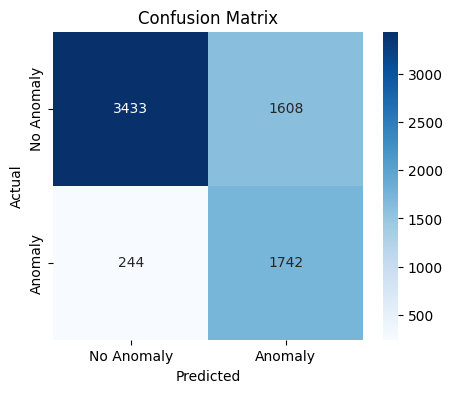

In [138]:
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Anomaly", "Anomaly"], yticklabels=["No Anomaly", "Anomaly"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [139]:
print(classification_report(all_labels, all_preds, digits=4))

              precision    recall  f1-score   support

           0     0.9336    0.6810    0.7876      5041
           1     0.5200    0.8771    0.6529      1986

    accuracy                         0.7364      7027
   macro avg     0.7268    0.7791    0.7202      7027
weighted avg     0.8167    0.7364    0.7495      7027

